<a href="https://colab.research.google.com/github/jkworldchampion/Military_CodingStudy/blob/main/deeplearning/basic_deeplearning_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Colab_Notebooks/Machine_learning/book/basic_deeplearning/deep-learning-from-scratch

/content/drive/MyDrive/Colab_Notebooks/Machine_learning/book/basic_deeplearning/deep-learning-from-scratch


# 학습 관련 기술들

이번 장에서는 신경망 학습의 핵심 개념들을 공부할 것이다. 
- 가중치 매개변수의 최적값을 탐색하는 최적화 방법
- 가중치 매개변수 초기값, 하이퍼파라미터 설정 방법
- 오버피칭 대응책인 가중치 감소와 드롭아웃 등의 정규화 방법   
- 마지막으로 최근 많은 연구에서 사용하는 배치 정규화도 알아볼 것이다.  

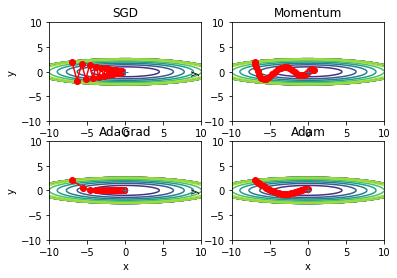

In [ ]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from common.optimizer import *


def f(x, y):
    return x**2 / 20.0 + y**2  # 적당한 함수 정의 


def df(x, y):
    return x / 10.0, 2.0*y   # f(x)의 도함수

init_pos = (-7.0, 2.0)  # 시작점을 설정한다.
params = {}  # 파라미터를 담을 공간
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}  # 기울기를 담을 공간
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()   # OrderedDict란 데이터의 순서를 보장해주는 딕셔너리
optimizers["SGD"] = SGD(lr=0.95)  
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)  # Adam은 하이퍼파라미터를 3개를 받는다. 학습률a, 일차모멘텀용 계수b, 이차모멘텀용 계수c

idx = 1

for key in optimizers:
    # 옵티마이저별 초기화 진행
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    # 
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])  # 각각의 기울기를 저장
        optimizer.update(params, grads)  # params['x'], params['y'] 이동
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y)  
    Z = f(X, Y)
    
    # 외곽선 단순화
    mask = Z > 7  
    Z[mask] = 0   # z값이 너무 큰 값은 지저분하기에 안보이게 설정
    
    # 그래프 그리기
    plt.subplot(2, 2, idx)  # 그래프 4개를 그려야함
    idx += 1 
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

## MNIST 데이터셋으로 본 갱신 방법 비교

===========iteration:0===========
SGD:2.2877884108431568
Momentum:2.426587673399796
AdaGrad:2.1937185932770342
Adam:2.217363274316585
===========iteration:100===========
SGD:1.7141943033617528
Momentum:0.42598569961955113
AdaGrad:0.190963287311182
Adam:0.2801221940520358
===========iteration:200===========
SGD:0.8146587536240953
Momentum:0.2168015779029568
AdaGrad:0.10046476218137337
Adam:0.17271132233773692
===========iteration:300===========
SGD:0.5707219996352431
Momentum:0.1559300481731097
AdaGrad:0.05461784319110328
Adam:0.08832845451768807
===========iteration:400===========
SGD:0.4960837155046462
Momentum:0.13884910281520757
AdaGrad:0.08727034899565399
Adam:0.11794223247089018
===========iteration:500===========
SGD:0.44217948932476836
Momentum:0.22120336727972223
AdaGrad:0.05693019812760618
Adam:0.14860301326666928
===========iteration:600===========
SGD:0.28559522455746844
Momentum:0.06827312359512902
AdaGrad:0.026558498509864626
Adam:0.034073499246143224
===========iteration:

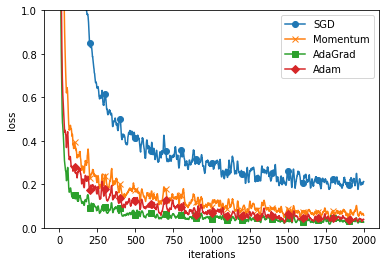

In [ ]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import matplotlib.pyplot as plt
import numpy as np
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 1000


# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

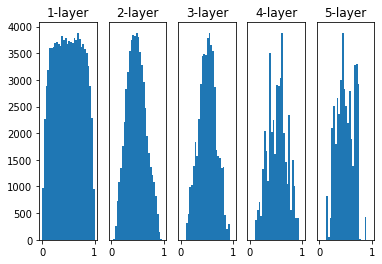

In [ ]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 초깃값을 다양하게 바꿔가며 실험해보자！
    # w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 활성화 함수도 바꿔가며 실험해보자！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

===========iteration:0===========
std=0.01:2.30255486594765
Xavier:2.3031316807385007
He:2.3084511330350503
===========iteration:100===========
std=0.01:2.3024204805334936
Xavier:2.238550425641158
He:1.4278124520950342
===========iteration:200===========
std=0.01:2.3025321400061416
Xavier:2.114786984342519
He:0.7271825325854002
===========iteration:300===========
std=0.01:2.302617934995298
Xavier:1.9123866839403538
He:0.5761183486058352
===========iteration:400===========
std=0.01:2.3018285761880137
Xavier:1.5277690800770674
He:0.3447985577903403
===========iteration:500===========
std=0.01:2.3035712258508187
Xavier:1.1502497953314812
He:0.34900857547657615
===========iteration:600===========
std=0.01:2.302712783419968
Xavier:0.8934390561662746
He:0.2964271758184442
===========iteration:700===========
std=0.01:2.2997521697625785
Xavier:0.8065069058514374
He:0.39563227194735506
===========iteration:800===========
std=0.01:2.302390807741999
Xavier:0.643700603153231
He:0.29348556200467163

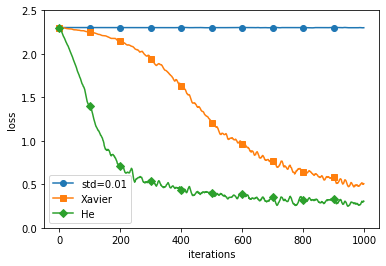

In [ ]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 1000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

============== 1/16 ==============
epoch:0 | 0.105 - 0.091


/content/drive/MyDrive/Colab_Notebooks/Machine_learning/book/basic_deeplearning/deep-learning-from-scratch/common/functions.py:34: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=0)


epoch:1 | 0.097 - 0.096
epoch:2 | 0.097 - 0.119
epoch:3 | 0.097 - 0.157
epoch:4 | 0.097 - 0.18
epoch:5 | 0.097 - 0.197
epoch:6 | 0.097 - 0.213
epoch:7 | 0.097 - 0.242
epoch:8 | 0.097 - 0.258
epoch:9 | 0.097 - 0.274
epoch:10 | 0.097 - 0.281
epoch:11 | 0.097 - 0.309
epoch:12 | 0.097 - 0.318
epoch:13 | 0.097 - 0.332
epoch:14 | 0.097 - 0.36
epoch:15 | 0.097 - 0.377
epoch:16 | 0.097 - 0.387
epoch:17 | 0.097 - 0.398
epoch:18 | 0.097 - 0.41


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.427
============== 2/16 ==============
epoch:0 | 0.087 - 0.087


/content/drive/MyDrive/Colab_Notebooks/Machine_learning/book/basic_deeplearning/deep-learning-from-scratch/common/multi_layer_net_extend.py:104: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/content/drive/MyDrive/Colab_Notebooks/Machine_learning/book/basic_deeplearning/deep-learning-from-scratch/common/multi_layer_net_extend.py:104: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


epoch:1 | 0.097 - 0.069
epoch:2 | 0.097 - 0.081
epoch:3 | 0.097 - 0.112
epoch:4 | 0.097 - 0.134
epoch:5 | 0.097 - 0.163
epoch:6 | 0.097 - 0.172
epoch:7 | 0.097 - 0.19
epoch:8 | 0.097 - 0.215
epoch:9 | 0.097 - 0.237
epoch:10 | 0.097 - 0.267
epoch:11 | 0.097 - 0.281
epoch:12 | 0.097 - 0.305
epoch:13 | 0.097 - 0.333
epoch:14 | 0.097 - 0.35
epoch:15 | 0.097 - 0.368
epoch:16 | 0.097 - 0.394
epoch:17 | 0.097 - 0.415
epoch:18 | 0.097 - 0.44


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.457
============== 3/16 ==============
epoch:0 | 0.116 - 0.051
epoch:1 | 0.3 - 0.085
epoch:2 | 0.377 - 0.126
epoch:3 | 0.48 - 0.164
epoch:4 | 0.558 - 0.192
epoch:5 | 0.615 - 0.239
epoch:6 | 0.672 - 0.283
epoch:7 | 0.707 - 0.323
epoch:8 | 0.751 - 0.35
epoch:9 | 0.789 - 0.389
epoch:10 | 0.812 - 0.411
epoch:11 | 0.846 - 0.444
epoch:12 | 0.862 - 0.457
epoch:13 | 0.88 - 0.478
epoch:14 | 0.89 - 0.502
epoch:15 | 0.908 - 0.515
epoch:16 | 0.917 - 0.543
epoch:17 | 0.925 - 0.55
epoch:18 | 0.94 - 0.575


No handles with labels found to put in legend.


epoch:19 | 0.948 - 0.602
============== 4/16 ==============
epoch:0 | 0.136 - 0.098
epoch:1 | 0.251 - 0.122
epoch:2 | 0.39 - 0.207
epoch:3 | 0.49 - 0.277
epoch:4 | 0.542 - 0.348
epoch:5 | 0.6 - 0.396
epoch:6 | 0.649 - 0.451
epoch:7 | 0.672 - 0.493
epoch:8 | 0.713 - 0.531
epoch:9 | 0.729 - 0.564
epoch:10 | 0.748 - 0.603
epoch:11 | 0.782 - 0.617
epoch:12 | 0.792 - 0.646
epoch:13 | 0.787 - 0.663
epoch:14 | 0.806 - 0.688
epoch:15 | 0.821 - 0.707
epoch:16 | 0.821 - 0.73
epoch:17 | 0.845 - 0.747
epoch:18 | 0.859 - 0.758


No handles with labels found to put in legend.


epoch:19 | 0.861 - 0.771
============== 5/16 ==============
epoch:0 | 0.12 - 0.102
epoch:1 | 0.137 - 0.176
epoch:2 | 0.15 - 0.3
epoch:3 | 0.152 - 0.441
epoch:4 | 0.161 - 0.521
epoch:5 | 0.175 - 0.595
epoch:6 | 0.18 - 0.653
epoch:7 | 0.197 - 0.698
epoch:8 | 0.208 - 0.727
epoch:9 | 0.213 - 0.75
epoch:10 | 0.227 - 0.768
epoch:11 | 0.231 - 0.786
epoch:12 | 0.233 - 0.798
epoch:13 | 0.235 - 0.812
epoch:14 | 0.236 - 0.825
epoch:15 | 0.24 - 0.831
epoch:16 | 0.242 - 0.843
epoch:17 | 0.253 - 0.857
epoch:18 | 0.26 - 0.864


No handles with labels found to put in legend.


epoch:19 | 0.266 - 0.874
============== 6/16 ==============
epoch:0 | 0.096 - 0.125
epoch:1 | 0.111 - 0.23
epoch:2 | 0.115 - 0.453
epoch:3 | 0.138 - 0.56
epoch:4 | 0.123 - 0.624
epoch:5 | 0.117 - 0.683
epoch:6 | 0.116 - 0.716
epoch:7 | 0.116 - 0.748
epoch:8 | 0.116 - 0.775
epoch:9 | 0.129 - 0.811
epoch:10 | 0.116 - 0.823
epoch:11 | 0.124 - 0.856
epoch:12 | 0.145 - 0.871
epoch:13 | 0.127 - 0.884
epoch:14 | 0.12 - 0.894
epoch:15 | 0.17 - 0.907
epoch:16 | 0.179 - 0.923
epoch:17 | 0.183 - 0.932
epoch:18 | 0.184 - 0.937


No handles with labels found to put in legend.


epoch:19 | 0.179 - 0.947
============== 7/16 ==============
epoch:0 | 0.1 - 0.11
epoch:1 | 0.123 - 0.206
epoch:2 | 0.117 - 0.467
epoch:3 | 0.117 - 0.604
epoch:4 | 0.117 - 0.699
epoch:5 | 0.117 - 0.79
epoch:6 | 0.117 - 0.835
epoch:7 | 0.117 - 0.869
epoch:8 | 0.117 - 0.892
epoch:9 | 0.117 - 0.911
epoch:10 | 0.117 - 0.935
epoch:11 | 0.117 - 0.94
epoch:12 | 0.117 - 0.95
epoch:13 | 0.117 - 0.962
epoch:14 | 0.117 - 0.966
epoch:15 | 0.117 - 0.972
epoch:16 | 0.117 - 0.976
epoch:17 | 0.117 - 0.977
epoch:18 | 0.117 - 0.98


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.983
============== 8/16 ==============
epoch:0 | 0.097 - 0.104
epoch:1 | 0.117 - 0.388
epoch:2 | 0.117 - 0.625
epoch:3 | 0.116 - 0.72
epoch:4 | 0.116 - 0.778
epoch:5 | 0.116 - 0.83
epoch:6 | 0.116 - 0.853
epoch:7 | 0.116 - 0.887
epoch:8 | 0.116 - 0.92
epoch:9 | 0.116 - 0.945
epoch:10 | 0.116 - 0.954
epoch:11 | 0.117 - 0.982
epoch:12 | 0.117 - 0.99
epoch:13 | 0.117 - 0.992
epoch:14 | 0.117 - 0.995
epoch:15 | 0.117 - 0.996
epoch:16 | 0.117 - 0.997
epoch:17 | 0.117 - 0.998
epoch:18 | 0.117 - 0.999


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.999
============== 9/16 ==============
epoch:0 | 0.093 - 0.106
epoch:1 | 0.097 - 0.452
epoch:2 | 0.116 - 0.663
epoch:3 | 0.116 - 0.744
epoch:4 | 0.116 - 0.833
epoch:5 | 0.116 - 0.87
epoch:6 | 0.116 - 0.893
epoch:7 | 0.116 - 0.909
epoch:8 | 0.116 - 0.939
epoch:9 | 0.116 - 0.975
epoch:10 | 0.116 - 0.982
epoch:11 | 0.116 - 0.994
epoch:12 | 0.116 - 0.995
epoch:13 | 0.116 - 0.995
epoch:14 | 0.116 - 0.998
epoch:15 | 0.116 - 1.0
epoch:16 | 0.116 - 1.0
epoch:17 | 0.116 - 1.0
epoch:18 | 0.116 - 1.0


No handles with labels found to put in legend.


epoch:19 | 0.117 - 1.0
============== 10/16 ==============
epoch:0 | 0.105 - 0.125
epoch:1 | 0.116 - 0.576
epoch:2 | 0.116 - 0.729
epoch:3 | 0.116 - 0.775
epoch:4 | 0.116 - 0.795
epoch:5 | 0.116 - 0.801
epoch:6 | 0.116 - 0.832
epoch:7 | 0.116 - 0.874
epoch:8 | 0.116 - 0.906
epoch:9 | 0.116 - 0.978
epoch:10 | 0.116 - 0.98
epoch:11 | 0.116 - 0.993
epoch:12 | 0.116 - 0.99
epoch:13 | 0.116 - 0.998
epoch:14 | 0.116 - 0.996
epoch:15 | 0.116 - 0.999
epoch:16 | 0.116 - 0.999
epoch:17 | 0.116 - 0.938
epoch:18 | 0.116 - 0.99


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.997
============== 11/16 ==============
epoch:0 | 0.116 - 0.189
epoch:1 | 0.116 - 0.676
epoch:2 | 0.116 - 0.808
epoch:3 | 0.116 - 0.81
epoch:4 | 0.116 - 0.904
epoch:5 | 0.116 - 0.842
epoch:6 | 0.116 - 0.94
epoch:7 | 0.116 - 0.975
epoch:8 | 0.116 - 0.952
epoch:9 | 0.116 - 0.976
epoch:10 | 0.117 - 0.97
epoch:11 | 0.116 - 0.982
epoch:12 | 0.116 - 0.99
epoch:13 | 0.116 - 0.989
epoch:14 | 0.116 - 0.984
epoch:15 | 0.116 - 0.991
epoch:16 | 0.116 - 0.991
epoch:17 | 0.116 - 0.991
epoch:18 | 0.116 - 0.994


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.988
============== 12/16 ==============
epoch:0 | 0.117 - 0.191
epoch:1 | 0.117 - 0.315
epoch:2 | 0.117 - 0.491
epoch:3 | 0.117 - 0.52
epoch:4 | 0.117 - 0.519
epoch:5 | 0.117 - 0.52
epoch:6 | 0.117 - 0.597
epoch:7 | 0.117 - 0.605
epoch:8 | 0.117 - 0.606
epoch:9 | 0.117 - 0.615
epoch:10 | 0.117 - 0.611
epoch:11 | 0.117 - 0.669
epoch:12 | 0.117 - 0.708
epoch:13 | 0.117 - 0.711
epoch:14 | 0.117 - 0.713
epoch:15 | 0.117 - 0.801
epoch:16 | 0.117 - 0.713
epoch:17 | 0.117 - 0.812
epoch:18 | 0.117 - 0.786


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.793
============== 13/16 ==============
epoch:0 | 0.117 - 0.202
epoch:1 | 0.116 - 0.488
epoch:2 | 0.117 - 0.499
epoch:3 | 0.116 - 0.53
epoch:4 | 0.117 - 0.585
epoch:5 | 0.117 - 0.601
epoch:6 | 0.116 - 0.605
epoch:7 | 0.116 - 0.607
epoch:8 | 0.116 - 0.593
epoch:9 | 0.116 - 0.606
epoch:10 | 0.116 - 0.609
epoch:11 | 0.116 - 0.657
epoch:12 | 0.116 - 0.649
epoch:13 | 0.116 - 0.658
epoch:14 | 0.116 - 0.672
epoch:15 | 0.116 - 0.628
epoch:16 | 0.117 - 0.637
epoch:17 | 0.116 - 0.698
epoch:18 | 0.116 - 0.693


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.712
============== 14/16 ==============
epoch:0 | 0.116 - 0.1
epoch:1 | 0.097 - 0.317
epoch:2 | 0.117 - 0.381
epoch:3 | 0.117 - 0.411
epoch:4 | 0.117 - 0.479
epoch:5 | 0.117 - 0.507
epoch:6 | 0.117 - 0.503
epoch:7 | 0.117 - 0.516
epoch:8 | 0.117 - 0.505
epoch:9 | 0.117 - 0.511
epoch:10 | 0.117 - 0.511
epoch:11 | 0.117 - 0.225
epoch:12 | 0.117 - 0.493
epoch:13 | 0.117 - 0.514
epoch:14 | 0.117 - 0.516
epoch:15 | 0.117 - 0.508
epoch:16 | 0.117 - 0.519
epoch:17 | 0.117 - 0.522
epoch:18 | 0.117 - 0.522


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.521
============== 15/16 ==============
epoch:0 | 0.1 - 0.135
epoch:1 | 0.116 - 0.24
epoch:2 | 0.116 - 0.365
epoch:3 | 0.116 - 0.407
epoch:4 | 0.116 - 0.412
epoch:5 | 0.116 - 0.413
epoch:6 | 0.117 - 0.481
epoch:7 | 0.117 - 0.439
epoch:8 | 0.117 - 0.453
epoch:9 | 0.117 - 0.471
epoch:10 | 0.116 - 0.478
epoch:11 | 0.116 - 0.478
epoch:12 | 0.116 - 0.504
epoch:13 | 0.116 - 0.501
epoch:14 | 0.117 - 0.503
epoch:15 | 0.117 - 0.5
epoch:16 | 0.117 - 0.515
epoch:17 | 0.117 - 0.5
epoch:18 | 0.117 - 0.512


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.512
============== 16/16 ==============
epoch:0 | 0.1 - 0.111
epoch:1 | 0.117 - 0.219
epoch:2 | 0.117 - 0.313
epoch:3 | 0.117 - 0.317
epoch:4 | 0.117 - 0.399
epoch:5 | 0.116 - 0.403
epoch:6 | 0.116 - 0.411
epoch:7 | 0.116 - 0.407
epoch:8 | 0.116 - 0.411
epoch:9 | 0.116 - 0.411
epoch:10 | 0.116 - 0.406
epoch:11 | 0.116 - 0.416
epoch:12 | 0.116 - 0.418
epoch:13 | 0.116 - 0.414
epoch:14 | 0.116 - 0.425
epoch:15 | 0.116 - 0.425
epoch:16 | 0.116 - 0.421
epoch:17 | 0.116 - 0.424
epoch:18 | 0.116 - 0.423
epoch:19 | 0.116 - 0.335


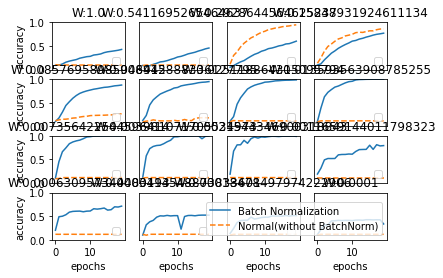

In [ ]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 그래프 그리기==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()